Задача: выделить лояльных покупателей (кластеризация).  

In [1]:
# обработка данных
import numpy as np
import pandas as pd

# визуализация
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

# обучение и оценка
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

План работы:    

**0. Загрузка и подготовка данных**  
**1. Разведочный анализ**  
- 1.1. Доставленные/отмененные
- 1.2. Категории  
- 1.3. Регионы  
- 1.4. Доставленные: общий доход на покупателя, средний чек, количество покупок, частота, выбросы и аномалии:   
        1.4а. Общая сумма по деньгам на каждого покупателя  
        1.4б. Средний чек на каждого покупателя  
        1.4в. Частота покупки на каждого покупателя  
        1.4г. Разнообразие товарных категорий на каждого покупателя
        1.4д. Пересечение выбросов по общей сумме, среднему чеку и частоте заказов   
- 1.5. Выводы по разведочному анализу  

**2. Бизнес-метрики**  
- 2.1. Расчет CRR, CR, ACL + изменение количества покупателей  
- 2.2. Расчет RPR, AOV, PF, CV  
- 2.3. Единая таблица и анализ метрик  
- 2.4. Выводы по бизнес-метрикам  

**3. Выделение лояльных покупателей, критерии и оценка**  
- 3.1. Расчет кластеризующих показателей  
- 3.2. Алгоритм kmeans для выделения лояльных  
- 3.3. Проверка кластеризации на бизнес-логику  
- 3.4. Выводы по кластеризации  

# 0. Загрузка и подготовка данных

In [2]:
# загрузим данные

df = pd.read_csv('D:\\Work\\data\\marketplace\\test_data.csv', sep=';')
df

,creation_date,region_id,customer_id,order_id,order_status,category_id,order_sum,items_qty
0,27.11.2019,1200,1001320890,21929828,DELIVERED,7,824,1
1,04.11.2018,150,241257124,8127000,DELIVERED,4,1199,2
2,23.01.2019,1125,399269970,9669842,DELIVERED,4,618,1
3,15.10.2019,100,654445333,18865900,DELIVERED,14,1394,1
4,30.01.2019,875,770011847,9793312,DELIVERED,2,4115,1
...,...,...,...,...,...,...,...,...
692918,21.12.2019,1225,890928366,24365774,CANCELLED,16,32703,1
692919,19.07.2019,1625,592611351,15152708,DELIVERED,5,1285,2
692920,22.09.2019,225,979695977,17688720,CANCELLED,4,877,1
692921,08.02.2019,1125,786541666,9952064,CANCELLED,15,2652,2


In [3]:
# добавим отдельными столбцами номера годов и месяцев (работать будем с помесячными данными)

df['creation_date'] = pd.to_datetime(df['creation_date'])
df.sort_values(by='creation_date', inplace=True)
df_month = pd.DatetimeIndex(df['creation_date']).month
df_year = pd.DatetimeIndex(df['creation_date']).year
df.insert(1, 'Year', pd.DatetimeIndex(df['creation_date']).year)
df.insert(2, 'Month', pd.DatetimeIndex(df['creation_date']).month)
df

,creation_date,Year,Month,region_id,customer_id,order_id,order_status,category_id,order_sum,items_qty
102217,2018-01-11,2018,1,975,239654800,8097264,DELIVERED,2,9397,1
283472,2018-01-11,2018,1,24275,759823047,8101192,DELIVERED,16,4550,1
361814,2018-01-11,2018,1,950,369653207,8101736,DELIVERED,16,7499,1
404926,2018-01-11,2018,1,225,542496200,8102704,CANCELLED,13,680,3
638139,2018-01-11,2018,1,1150,78347063,8099890,CANCELLED,16,14593,1
...,...,...,...,...,...,...,...,...,...,...
264522,2019-12-31,2019,12,1175,462447886,25209092,DELIVERED,16,27286,1
409150,2019-12-31,2019,12,24175,1010429215,25204122,DELIVERED,12,4981,1
264566,2019-12-31,2019,12,1075,93562625,25203548,DELIVERED,16,1893,1
301504,2019-12-31,2019,12,1100,574149524,25217628,CANCELLED,16,9038,1


In [4]:
# пропусков в данных нет, хорошо

df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 692923 entries, 102217 to 446138
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   creation_date  692923 non-null  datetime64[ns]
 1   Year           692923 non-null  int64         
 2   Month          692923 non-null  int64         
 3   region_id      692923 non-null  int64         
 4   customer_id    692923 non-null  int64         
 5   order_id       692923 non-null  int64         
 6   order_status   692923 non-null  object        
 7   category_id    692923 non-null  int64         
 8   order_sum      692923 non-null  int64         
 9   items_qty      692923 non-null  int64         
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 58.2+ MB


# 1. Разведочный анализ

Перед решением задачи определения критериев лояльности и собственно лояльных покупателей разберемся с природой данных, их распределением, посмотрим под разными углами.

In [5]:
# в сумме заказа (order_sum) большой размах (max - min) и std почти в два раза отклоняется от среднего - наверняка есть выбросы

df.describe()

,Year,Month,region_id,customer_id,order_id,category_id,order_sum,items_qty
count,692923.000000,692923.000000,6.929230e+05,6.929230e+05,6.929230e+05,692923.000000,692923.000000,692923.000000
mean,2018.929693,7.679060,2.547322e+04,5.134243e+08,1.649899e+07,9.641363,4569.446638,2.338824
std,0.255663,3.419272,1.812835e+05,3.302782e+08,4.706847e+06,5.007958,8183.647841,4.995050
min,2018.000000,1.000000,1.000000e+02,1.111301e+07,8.094900e+06,1.000000,501.000000,1.000000
25%,2019.000000,5.000000,9.250000e+02,1.853722e+08,1.281755e+07,4.000000,1090.000000,1.000000
50%,2019.000000,8.000000,1.075000e+03,5.418100e+08,1.641341e+07,11.000000,2167.000000,1.000000
75%,2019.000000,11.000000,1.225000e+03,8.377089e+08,2.030431e+07,14.000000,4517.000000,2.000000
max,2019.000000,12.000000,2.464350e+06,1.038556e+09,2.521999e+07,16.000000,263087.000000,392.000000


In [6]:
# за какой период данные? 14 месяцев, похоже почти с самого открытия в конце октября 2018

print('Первая дата в данных:', min(df['creation_date']))
print('Последняя дата в данных:', max(df['creation_date']))

Первая дата в данных: 2018-01-11 00:00:00
Последняя дата в данных: 2019-12-31 00:00:00


In [7]:
# для максимально свежей картины работать будем с 2019 годом, отложим в сторону 2018 год

df2018 = df[df['Year'] == 2018]
df = df[df['Year'] == 2019]
df

,creation_date,Year,Month,region_id,customer_id,order_id,order_status,category_id,order_sum,items_qty
529604,2019-01-01,2019,1,1175,759894626,9264274,DELIVERED,16,8021,1
486762,2019-01-01,2019,1,1175,38345282,9268482,CANCELLED,5,888,1
304498,2019-01-01,2019,1,1125,773011457,9265582,DELIVERED,16,8191,1
250381,2019-01-01,2019,1,1125,774046027,9266234,DELIVERED,16,8191,1
528016,2019-01-01,2019,1,1225,686211918,9271396,DELIVERED,12,8434,1
...,...,...,...,...,...,...,...,...,...,...
264522,2019-12-31,2019,12,1175,462447886,25209092,DELIVERED,16,27286,1
409150,2019-12-31,2019,12,24175,1010429215,25204122,DELIVERED,12,4981,1
264566,2019-12-31,2019,12,1075,93562625,25203548,DELIVERED,16,1893,1
301504,2019-12-31,2019,12,1100,574149524,25217628,CANCELLED,16,9038,1


#### 1.1. Доставленные/отмененные:

In [8]:
# посмотрим количество доставленных и отмененных заказов ПО КОЛИЧЕСТВУ и ПО СУММЕ ДЕНЕГ за год, оба показателя в %

df_cancl_deliv = df.groupby(['order_status'])['order_sum']

print('Количество отмененных:', df_cancl_deliv.count()[0], 'Количество выполненных:', df_cancl_deliv.count()[1])
print('Сумма в деньгах отмененных:', df_cancl_deliv.sum()[0], 'Сумма в деньгах выполненных:', df_cancl_deliv.sum()[1])
print('Процент количества отмененных заказов в целом за год:', df_cancl_deliv.count()[0] / (df_cancl_deliv.count()[0] + df_cancl_deliv.count()[1]) * 100)
print('Процент суммы, пришедшейся на отмененные заказы в целом за год:', df_cancl_deliv.sum()[0] / (df_cancl_deliv.sum()[0] + df_cancl_deliv.sum()[1]) * 100)

Количество отмененных: 195561 Количество выполненных: 448645
Сумма в деньгах отмененных: 1380366164 Сумма в деньгах выполненных: 1534382817
Процент количества отмененных заказов в целом за год: 30.356904468446427
Процент суммы, пришедшейся на отмененные заказы в целом за год: 47.357977410679815


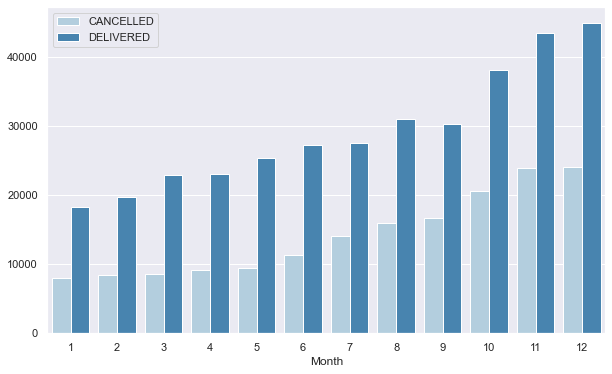

In [9]:
# посмотрим соотношение выполненных и отмененных по месяцам за 2019 год ПО КОЛИЧЕСТВУ ЗАКАЗОВ

df_2019_order_id_count = df.groupby(['Month','order_status'])['order_id'].nunique().to_frame()

plt.figure(figsize=(10,6))
sns.barplot(x = df_2019_order_id_count.index.get_level_values(0), y = df_2019_order_id_count.values[:, 0], hue = tuple(df_2019_order_id_count.index.get_level_values(1)), data=df_2019_order_id_count, palette='Blues')

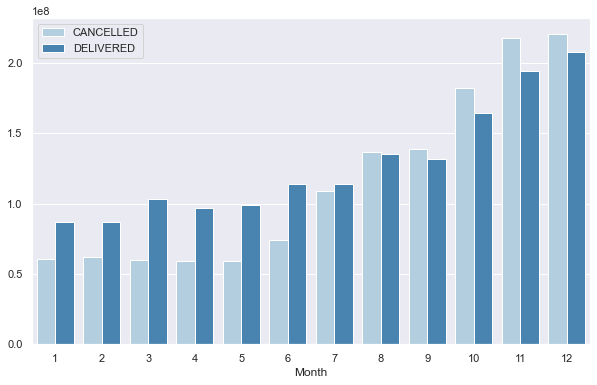

In [10]:
# посмотрим соотношение выполненных и отмененных по месяцам за 2019 год ПО СУММЕ ДЕНЕГ

df_2019_order_id_sum = df.groupby(['Month','order_status'])['order_sum'].sum().to_frame()

plt.figure(figsize=(10,6))
sns.barplot(x = df_2019_order_id_sum.index.get_level_values(0), y = df_2019_order_id_sum.values[:, 0], hue = tuple(df_2019_order_id_sum.index.get_level_values(1)), data=df_2019_order_id_sum, palette='Blues')

Количество заказов (и выполненных, и отмененных) скорее всего росло в силу рекламы и активного роста, а вот суммы по отказам стали опережать выполненные с середины года. Возможно, сыграло повышение суммы для использования купона (на скидку или бесплатную доставку). В результате мог быть эффект, что покупатели "добирали" до нужной суммы и спустя время передумывали/находили условия лучше в другом месте.

#### 1.2. Категории:

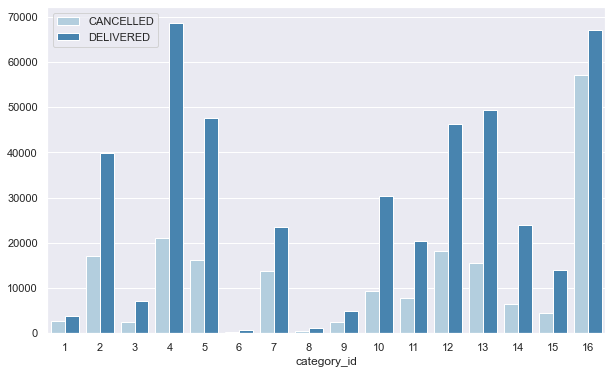

In [11]:
# посмотрим, что с категориями ПО КОЛИЧЕСТВУ ЗАКАЗОВ

cat_id_count = df.groupby(['category_id', 'order_status'])['order_id'].nunique().to_frame()
plt.figure(figsize=(10, 6))
sns.barplot(x = cat_id_count.index.get_level_values(0), y = cat_id_count.values[:, 0], hue = tuple(cat_id_count.index.get_level_values(1)), data=cat_id_count, palette='Blues')

# ***можно заметить проблемы с 16 категорией, много отказов, где она фигурирует 

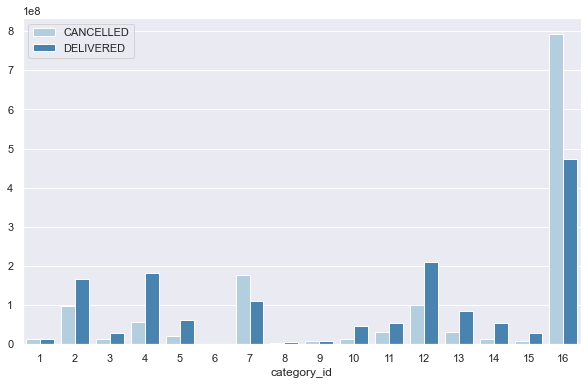

In [12]:
# посмотрим, что с категориями ПО СУММЕ ДЕНЕГ

cat_id_sum = df.groupby(['category_id', 'order_status'])['order_sum'].sum().to_frame()
plt.figure(figsize=(10, 6))
sns.barplot(x = cat_id_sum.index.get_level_values(0), y = cat_id_sum.values[:, 0], hue = tuple(cat_id_sum.index.get_level_values(1)), data=cat_id_sum, palette='Blues')

In [13]:
# посмотрим среднюю стоимость одной единицы товара в каждой категории

cat_by_once = (df.groupby(['category_id'])['order_sum'].sum() / df.groupby(['category_id'])['items_qty'].sum()).sort_values(ascending=False)
cat_by_once

category_id
16    8925.174587
7     5964.579667
8     5350.192025
2     4052.174870
1     3240.771646
3     3016.714993
12    2674.257771
11    1706.188607
15    1374.382129
9     1325.041268
14     891.916208
13     747.705710
6      742.644343
4      604.157706
5      421.940462
10     321.044959
dtype: float64

<BarContainer object of 16 artists>

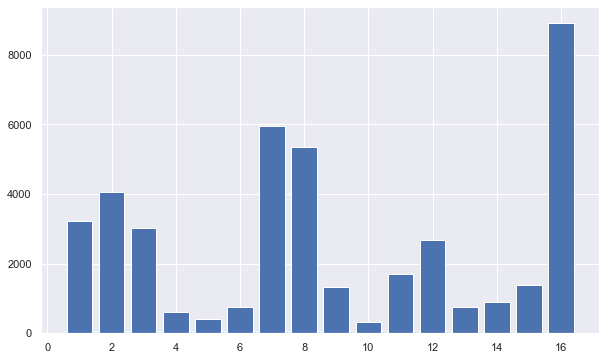

In [14]:
plt.figure(figsize=(10, 6))
plt.bar(x = cat_by_once.index, height = cat_by_once.values, data=cat_by_once)

Ясно, что 16я категория популярная и дорогая. Возможно бытовая техника, гаджеты или другая дорогая техника, покупку которой обдумывают серьезно, потому высокий процент отказов. Вероятно делают заказ, а потом находят другой магазин с лучшими условиями по цене/доставке и т.д.  
Схожая история с 7й категорией: так же дорогая и есть превышение отказов по сумме.

In [15]:
# посмотрим, заказы с какими категориями наиболее "отказные" в процентном соотношении ПО КОЛИЧЕСТВУ к общему объему категории (заказ+отказ) 

cat_id_not_cancelled_count = cat_id_count
cat_id_not_cancelled_count = cat_id_not_cancelled_count.unstack().reset_index(level=0, drop=True).set_index(cat_id_count.index.get_level_values(0).unique())
cat_id_not_cancelled_count.columns = cat_id_not_cancelled_count.columns.droplevel(0)
cat_id_not_cancelled_count['DIFF'] = cat_id_not_cancelled_count['CANCELLED'] / (cat_id_not_cancelled_count['CANCELLED'] + cat_id_not_cancelled_count['DELIVERED'])
cat_id_not_cancelled_count['DIFF'].sort_values(ascending=False).to_frame()

,DIFF
category_id,
16,0.460333
1,0.401386
7,0.368203
6,0.350554
9,0.336045
2,0.299371
12,0.282165
11,0.278806
8,0.266582


In [16]:
# посмотрим, заказы с какими категориями наиболее "отказные" в процентном соотношении ПО СУММЕ к общему объему категории (заказ+отказ) 

cat_id_not_cancelled_money = cat_id_sum
cat_id_not_cancelled_money = cat_id_not_cancelled_money.unstack().reset_index(level=0, drop=True).set_index(cat_id_sum.index.get_level_values(0).unique())
cat_id_not_cancelled_money.columns = cat_id_not_cancelled_money.columns.droplevel(0)
cat_id_not_cancelled_money['DIFF'] = cat_id_not_cancelled_money['CANCELLED'] / (cat_id_not_cancelled_money['CANCELLED'] + cat_id_not_cancelled_money['DELIVERED'])
cat_id_not_cancelled_money['DIFF'].sort_values(ascending=False).to_frame()

,DIFF
category_id,
16,0.626982
7,0.613568
9,0.465869
1,0.462732
6,0.387738
2,0.367892
11,0.358219
12,0.321398
3,0.302862


В целом в топе как по количеству, так и по сумме одни и те же категории. Как и ожидали 16я и 7я категории лидеры, 1я очень мала сама по себе и скромна в обороте.

#### 1.3. Регионы:

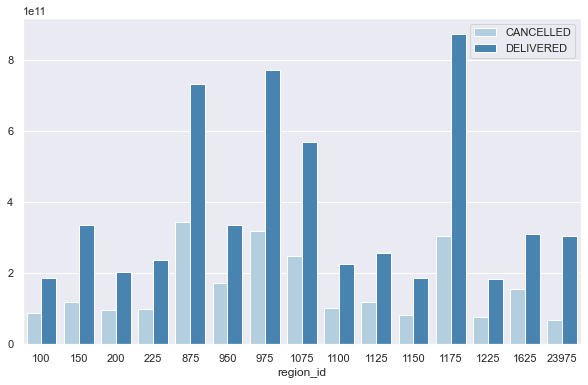

In [17]:
# теперь для регионов, но в виду их количества внимательно изучим только топ 15 регионов по отказам ПО КОЛИЧЕСТВУ ЗАКАЗОВ

reg_id_top15_count = df.groupby(['region_id'])['order_id'].count()
reg_id_top15_count = reg_id_top15_count.sort_values(ascending=False)[:15]

reg_id_top15_count = df[df['region_id'].isin(reg_id_top15_count.index)].groupby(['region_id', 'order_status'])['order_id'].sum().to_frame()

plt.figure(figsize=(10, 6))
sns.barplot(x = reg_id_top15_count.index.get_level_values(0), y = reg_id_top15_count.values[:, 0], hue = tuple(reg_id_top15_count.index.get_level_values(1)), data=reg_id_top15_count, palette='Blues')

In [18]:
# что в процентах от всего КОЛИЧЕСТВА ЗАКАЗОВ региона будет

reg_id_not_cancelled_count_p = reg_id_top15_count
reg_id_not_cancelled_count_p = reg_id_not_cancelled_count_p.unstack().reset_index(level=0, drop=True).set_index(reg_id_top15_count.index.get_level_values(0).unique())
reg_id_not_cancelled_count_p.columns = reg_id_not_cancelled_count_p.columns.droplevel(0)
reg_id_not_cancelled_count_p['DIFF'] = reg_id_not_cancelled_count_p['CANCELLED'] / (reg_id_not_cancelled_count_p['CANCELLED'] + reg_id_not_cancelled_count_p['DELIVERED'])
reg_id_not_cancelled_count_p['DIFF'].sort_values(ascending=False).to_frame()

,DIFF
region_id,
950,0.338864
1625,0.333309
875,0.320387
100,0.318827
1125,0.318448
200,0.318312
1150,0.310831
1100,0.310614
1075,0.303651


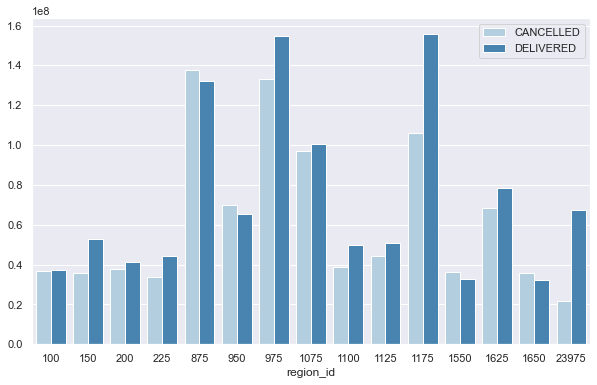

In [19]:
# теперь топ 15 регионов по отказам ПО СУММЕ ДЕНЕГ

reg_id_top15_money = df.groupby(['region_id'])['order_sum'].sum()
reg_id_top15_money = reg_id_top15_money.sort_values(ascending=False)[:15]

reg_id_top15_money = df[df['region_id'].isin(reg_id_top15_money.index)].groupby(['region_id', 'order_status'])['order_sum'].sum().to_frame()

plt.figure(figsize=(10, 6))
sns.barplot(x = reg_id_top15_money.index.get_level_values(0), y = reg_id_top15_money.values[:, 0], hue = tuple(reg_id_top15_money.index.get_level_values(1)), data=reg_id_top15_money, palette='Blues')

In [20]:
# что в процентах от всей СУММЫ ДЕНЕГ региона будет

reg_id_not_cancelled_money_p = reg_id_top15_money
reg_id_not_cancelled_money_p = reg_id_not_cancelled_money_p.unstack().reset_index(level=0, drop=True).set_index(reg_id_top15_money.index.get_level_values(0).unique())
reg_id_not_cancelled_money_p.columns = reg_id_not_cancelled_money_p.columns.droplevel(0)
reg_id_not_cancelled_money_p['DIFF'] = reg_id_not_cancelled_money_p['CANCELLED'] / (reg_id_not_cancelled_money_p['CANCELLED'] + reg_id_not_cancelled_money_p['DELIVERED'])
reg_id_not_cancelled_money_p['DIFF'].sort_values(ascending=False).to_frame()

,DIFF
region_id,
1650,0.526402
1550,0.524082
950,0.517278
875,0.510334
100,0.498168
1075,0.490556
200,0.477736
1625,0.467312
1125,0.466292


In [21]:
# посмотрим, какая доля от всех денег приходится на 875, 975, 1175, 1075, 1625 и 950 регионы 
# от общего оборота УЧИТЫВАЯ ТОЛЬКО ДОСТАВЛЕННЫЕ ЗАКАЗЫ

print('Доля регионов 875, 975, 1175, 1075, 1625, 950 во всех доставленных заказах, в %:', (df[(df['region_id'].isin([875, 975, 1175, 1075, 1625, 950])) & (df['order_status'] == 'DELIVERED')]['order_sum'].sum() / df[df['order_status'] == 'DELIVERED']['order_sum'].sum()) * 100)

Доля регионов 875, 975, 1175, 1075, 1625, 950 во всех доставленных заказах, в %: 44.78133412256532


Исходя в первую очередь из объемов по деньгам наибольшее внимание на себя обращают, в порядке убывания важности: 875 (очень большой дохода, но ещё больше потерянных на отказах денег), 975 и 1175 (очень большой объем потерь в деньгах), 1075, 1625 и 950 - очевидно в этих 3 регионах деньги и готовность покупать есть, но что-то ведет к большой сумме потерь в деньгах и количеству отмененных заказов. Вероятно, всё это это крупные города (может быть некоторые даже субрегионы). На эти 6 регионов приходится 45% доходов.

#### 1.4. Доставленные:  общий доход на покупателя, средний чек, количество покупок, частота, выбросы и аномалии:

In [22]:
# здесь и далее изучим ближе только выполненные заказы (исходя из цели задачи)

df = df[df['order_status'] == 'DELIVERED']
df

,creation_date,Year,Month,region_id,customer_id,order_id,order_status,category_id,order_sum,items_qty
529604,2019-01-01,2019,1,1175,759894626,9264274,DELIVERED,16,8021,1
304498,2019-01-01,2019,1,1125,773011457,9265582,DELIVERED,16,8191,1
250381,2019-01-01,2019,1,1125,774046027,9266234,DELIVERED,16,8191,1
528016,2019-01-01,2019,1,1225,686211918,9271396,DELIVERED,12,8434,1
126796,2019-01-01,2019,1,1625,796520652,9266324,DELIVERED,2,2554,3
...,...,...,...,...,...,...,...,...,...,...
111852,2019-12-31,2019,12,975,25933585,25218210,DELIVERED,2,9901,1
338718,2019-12-31,2019,12,150,263019119,25205856,DELIVERED,2,1450,1
264522,2019-12-31,2019,12,1175,462447886,25209092,DELIVERED,16,27286,1
409150,2019-12-31,2019,12,24175,1010429215,25204122,DELIVERED,12,4981,1


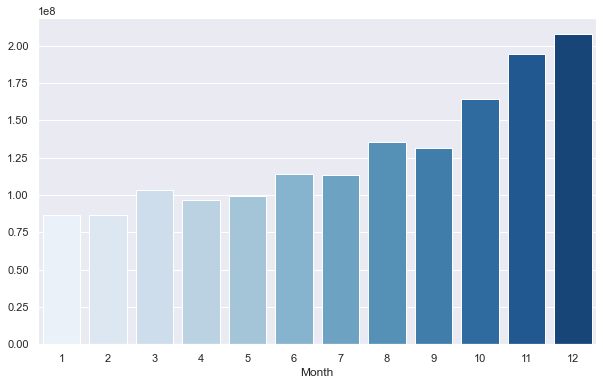

In [23]:
# посмотрим на общие суммы продаж по месяцам В ДЕНЬГАХ 

df_delivered_sum_month = df.groupby(['Month'])['order_sum'].sum().to_frame()

plt.figure(figsize=(10,6))
sns.barplot(x=df_delivered_sum_month.index, y = df_delivered_sum_month.values[:,0], data=df_delivered_sum_month, palette='Blues')

Очень силен фактор роста и рекламы (открытие в конце октября 2018, за ~2 месяца до 2019 года).

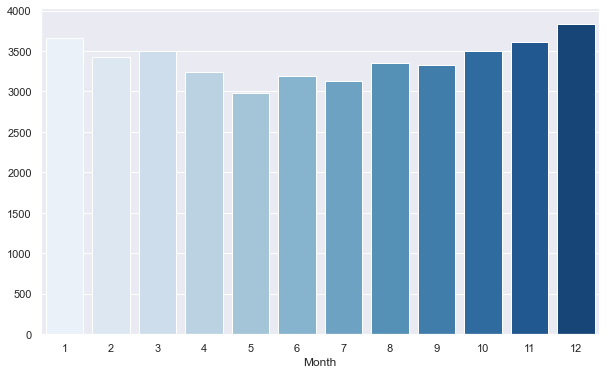

In [24]:
# посмотрим на средние суммы по месяцам В ДЕНЬГАХ (средняя сумма заказа)

df_delivered_mean_month = df.groupby(['Month'])['order_sum'].mean().to_frame()

plt.figure(figsize=(10,6))
sns.barplot(x=df_delivered_mean_month.index, y = df_delivered_mean_month.values[:,0], data=df_delivered_mean_month, palette='Blues')

Наводит на мысли о сезонности, но 1 год маловато для однозначного вывода об этом.

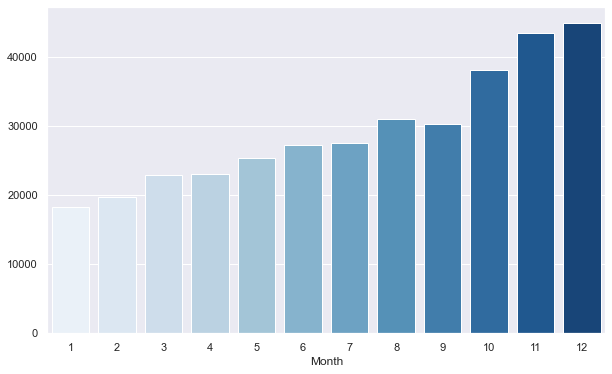

In [25]:
# посмотрим по месяцам КОЛИЧЕСТВО ЗАКАЗОВ 

df_delivered_trans_count = df.groupby(['Month'])['order_id'].nunique().to_frame()

plt.figure(figsize=(10,6))
sns.barplot(x=df_delivered_trans_count.index, y = df_delivered_trans_count.values[:,0], data=df_delivered_trans_count, palette='Blues')

Рост количества транзакций ещё один довод в пользу факторов быстрого роста и рекламы.

#### 1.4а. Общая сумма по деньгам на каждого покупателя:

In [26]:
# посмотрим ОБЩАЯ СУММА ПО ДЕНЬГАМ от покупок по каждому конкретному покупателю за весь период

df_order_sum = df.groupby(['customer_id'])['order_sum'].sum()
df_order_sum.sort_values()

customer_id
673603387        501
977330331        501
778650355        501
953112225        501
861804230        501
              ...   
873330132    2140085
27118041     2346399
359859048    2431264
866550828    3018129
557309662    5279846
Name: order_sum, Length: 195485, dtype: int64

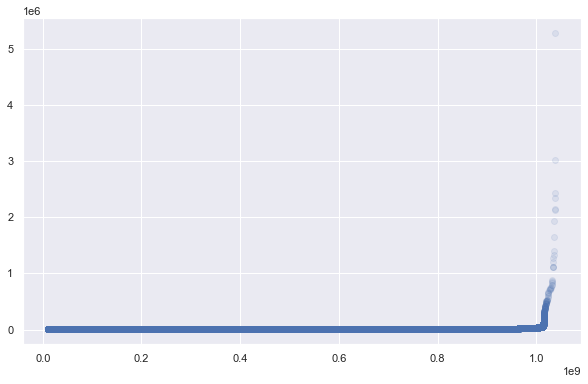

In [27]:
# очевидно есть сравнительно небольшое количество покупателей, у которых очень высокая ОБЩАЯ СУММА ПО ДЕНЬГАМ - это выбросы

plt.figure(figsize=(10, 6))
plt.scatter(x = df_order_sum.index, y = df_order_sum.sort_values(), alpha=0.1)

In [28]:
# прикинем разумные границы для выделения выбросов по ОБЩЕЙ СУММЕ на человека (в процентах от всех) - допустим это 60к+ 

print('Всего покупателей:', df_order_sum.count())
print('Количество покупателей с общей суммой покупки > 60000 рублей за год:', df_order_sum[df_order_sum > 60000].count())
print('Что составляет % от всех равный:', df_order_sum[df_order_sum > 60000].count() / df_order_sum.count() * 100)

Всего покупателей: 195485
Количество покупателей с общей суммой покупки > 60000 рублей за год: 1645
Что составляет % от всех равный: 0.8414967900350411


In [29]:
# посмотрим на тех, кто по ОБЩЕЙ СУММЕ потратил менее 60000 (99.2% от всех)

df_order_sum_nobig = df_order_sum[df_order_sum <= 60000] 
df_order_sum_nobig.sort_values()

customer_id
969844516      501
993565514      501
528419594      501
778650355      501
977330331      501
             ...  
134299169    59896
160343299    59909
862220363    59916
607223536    59916
529616975    59964
Name: order_sum, Length: 193840, dtype: int64

(array([33961., 31632., 33187., 19537., 14171., 10156.,  7441.,  7149.,
         5251.,  4023.,  3412.,  2795.,  2438.,  2059.,  1959.,  1561.,
         1298.,  1196.,   980.,   927.,   945.,   756.,   670.,   593.,
          524.,   498.,   429.,   401.,   405.,   304.,   269.,   226.,
          246.,   230.,   187.,   200.,   170.,   161.,   143.,   186.,
          167.,   125.,   150.,   130.,   129.,   113.,   109.,    94.,
           74.,    73.]),
 array([  501.  ,  1690.26,  2879.52,  4068.78,  5258.04,  6447.3 ,
         7636.56,  8825.82, 10015.08, 11204.34, 12393.6 , 13582.86,
        14772.12, 15961.38, 17150.64, 18339.9 , 19529.16, 20718.42,
        21907.68, 23096.94, 24286.2 , 25475.46, 26664.72, 27853.98,
        29043.24, 30232.5 , 31421.76, 32611.02, 33800.28, 34989.54,
        36178.8 , 37368.06, 38557.32, 39746.58, 40935.84, 42125.1 ,
        43314.36, 44503.62, 45692.88, 46882.14, 48071.4 , 49260.66,
        50449.92, 51639.18, 52828.44, 54017.7 , 55206.96, 56396.22

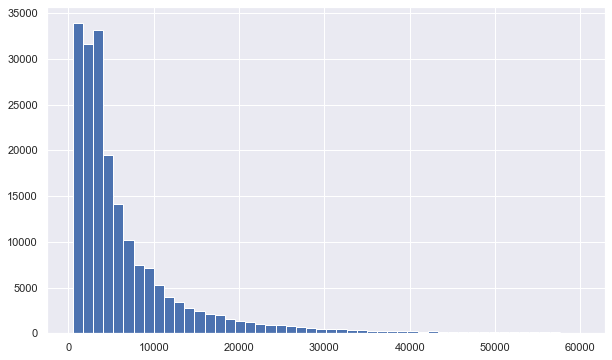

In [30]:
plt.figure(figsize=(10,6))
plt.hist(df_order_sum_nobig, bins=50)

Выглядит как логнормальное распределение, проверим взяв логарифм:

(array([ 241.,  233.,  569.,  672., 1038., 1082., 1417., 1288., 1527.,
        1490., 1810., 2116., 1858., 1974., 2340., 2334., 2974., 2606.,
        2710., 2732., 2534., 3113., 2659., 2785., 3793., 3933., 3100.,
        4112., 5587., 4609., 6198., 5942., 6345., 5582., 5398., 4597.,
        4656., 4816., 3969., 4463., 4411., 4169., 4097., 3688., 3553.,
        3017., 3048., 2986., 3593., 3276., 2680., 2869., 2430., 2377.,
        2185., 2032., 1955., 1810., 1728., 1785., 1454., 1388., 1268.,
        1156., 1143., 1078.,  955.,  872.,  749.,  709.,  695.,  523.,
         467.,  430.,  398.,  359.,  395.,  358.,  317.,  235.]),
 array([ 6.2166061 ,  6.27641727,  6.33622844,  6.39603961,  6.45585078,
         6.51566195,  6.57547312,  6.63528429,  6.69509546,  6.75490663,
         6.8147178 ,  6.87452897,  6.93434014,  6.9941513 ,  7.05396247,
         7.11377364,  7.17358481,  7.23339598,  7.29320715,  7.35301832,
         7.41282949,  7.47264066,  7.53245183,  7.592263  ,  7.65207417,
 

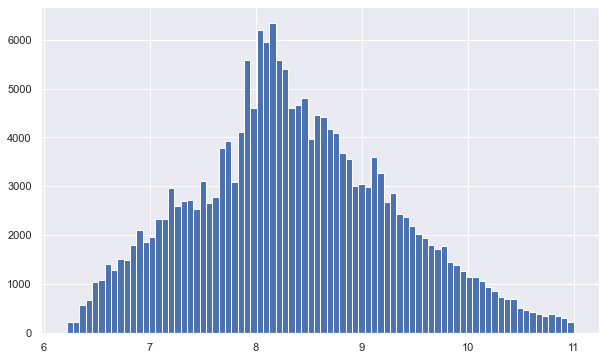

In [31]:
plt.figure(figsize=(10,6))
plt.hist(np.log(df_order_sum_nobig), bins=80)

Выходит да, всё верно, исходное распределение ОБЩИХ СУММ по покупателям логнормальное т.к. их логарифм имеет нормальное распределение.

#### 1.4б. Средний чек на каждого покупателя:

In [32]:
# теперь тоже самое для СРЕДНИХ ЧЕКОВ по каждому конкретному покупателю за весь период

df_order_mean = df.groupby(['customer_id'])['order_sum'].mean()
df_order_mean.sort_values()

customer_id
363589055       501.0
528419594       501.0
166450395       501.0
34269496        501.0
491672528       501.0
               ...   
666525086    123995.0
682090389    127115.0
141411004    141765.0
921470436    149046.0
377798721    169338.0
Name: order_sum, Length: 195485, dtype: float64

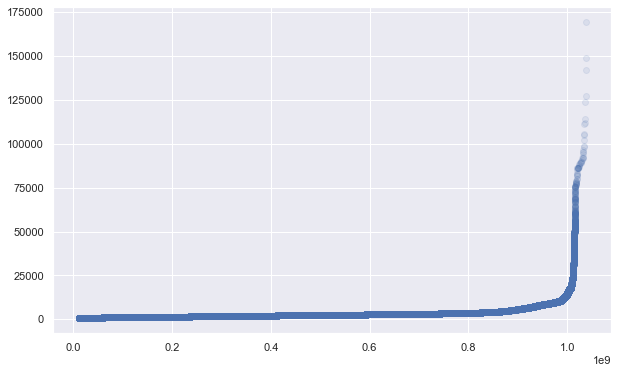

In [33]:
# так же сравнительно небольшое количество покупателей, у которых очень высокий СРЕДНИЙ ЧЕК - тоже выбросы

plt.figure(figsize=(10, 6))
plt.scatter(x = df_order_mean.index, y = df_order_mean.sort_values(), alpha=0.1)

In [34]:
# так же прикинем разумные границы для выделения выбросов по СРЕДНЕМУ чеку на человека (в процентах от всех) - допустим 30к+

print('Всего покупателей:', df_order_mean.count())
print('Количество покупателей со средней суммой покупки > 30000 рублей за год:', df_order_mean[df_order_mean > 30000].count())
print('Что составляет % от всех равный:', df_order_mean[df_order_mean > 30000].count() / df_order_mean.count() * 100)

Всего покупателей: 195485
Количество покупателей со средней суммой покупки > 30000 рублей за год: 1161
Что составляет % от всех равный: 0.5939074609305062


In [35]:
# изучим теперь тех, кто имел средний чек менее 30000 (99.4% от всех) 

df_order_mean_nobig = df_order_mean[df_order_mean <= 30000] 
df_order_mean_nobig.sort_values()

customer_id
977330331      501.0
959866748      501.0
534746614      501.0
921287186      501.0
993565514      501.0
              ...   
63832571     29979.0
957383008    29979.0
529616975    29982.0
855527783    29987.0
456111579    29987.0
Name: order_sum, Length: 194324, dtype: float64

(array([11746., 21270., 24128., 18991., 15193., 12868., 12252., 10627.,
         8570.,  6982.,  5272.,  4908.,  4321.,  3772.,  2829.,  2848.,
         2431.,  2026.,  1886.,  1466.,  1514.,  1046.,  1371.,  1818.,
         1175.,  1104.,   867.,   891.,   757.,   524.,   636.,   546.,
          481.,   380.,   454.,   377.,   271.,   348.,   343.,   338.,
          241.,   293.,   247.,   156.,   274.,   297.,   309.,   143.,
          177.,   127.,   170.,    85.,   111.,   132.,   106.,   105.,
          116.,   138.,    62.,    96.,    98.,    83.,    97.,    67.,
          120.,    46.,    89.,    93.,    76.,    93.,    52.,    55.,
           44.,    38.,    47.,    45.,    46.,    49.,    40.,    34.]),
 array([  501.   ,   869.575,  1238.15 ,  1606.725,  1975.3  ,  2343.875,
         2712.45 ,  3081.025,  3449.6  ,  3818.175,  4186.75 ,  4555.325,
         4923.9  ,  5292.475,  5661.05 ,  6029.625,  6398.2  ,  6766.775,
         7135.35 ,  7503.925,  7872.5  ,  8241.075,  860

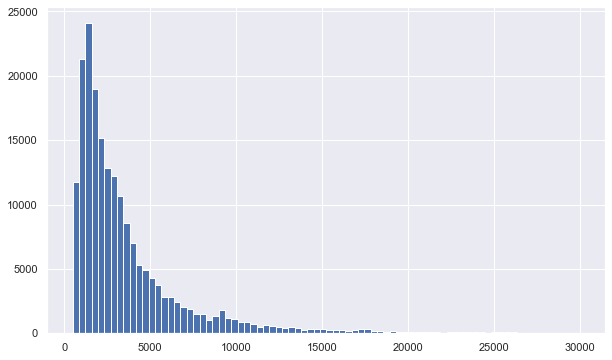

In [36]:
plt.figure(figsize=(10,6))
plt.hist(df_order_mean_nobig, bins=80)

Тоже выглядит как логнормальное распределение, проверим взяв логарифм:

(array([ 765.,  699., 1110., 1813., 2224., 2692., 3349., 4051., 4618.,
        5244., 6108., 6193., 8907., 7337., 7761., 7639., 7078., 6592.,
        8414., 6555., 7826., 7351., 8454., 7923., 6098., 6060., 5143.,
        5279., 4670., 4330., 3877., 3360., 3253., 2290., 2729., 3024.,
        2289., 1874., 1523., 1188., 1178.,  986.,  922.,  859.,  594.,
         499.,  484.,  478.,  361.,  273.]),
 array([ 6.2166061 ,  6.29844436,  6.38028263,  6.46212089,  6.54395915,
         6.62579741,  6.70763568,  6.78947394,  6.8713122 ,  6.95315046,
         7.03498873,  7.11682699,  7.19866525,  7.28050352,  7.36234178,
         7.44418004,  7.5260183 ,  7.60785657,  7.68969483,  7.77153309,
         7.85337135,  7.93520962,  8.01704788,  8.09888614,  8.1807244 ,
         8.26256267,  8.34440093,  8.42623919,  8.50807746,  8.58991572,
         8.67175398,  8.75359224,  8.83543051,  8.91726877,  8.99910703,
         9.08094529,  9.16278356,  9.24462182,  9.32646008,  9.40829834,
         9.49013

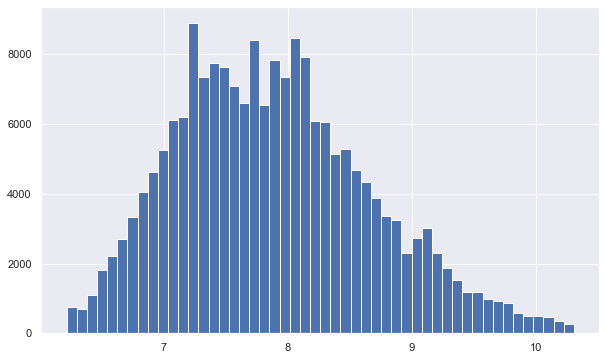

In [37]:
plt.figure(figsize=(10,6))
plt.hist(np.log(df_order_mean_nobig), bins=50)

Точно так же выходит да, всё верно, исходное распределение СРЕДНИХ ЧЕКОВ по покупателям логнормальное т.к. их логарифм имеет нормальное распределение.

#### 1.4в. Частота покупки на каждого покупателя:

In [38]:
# КОЛИЧЕСТВО ЗАКАЗОВ по каждому конкретному покупателю за весь период

df_delivered_freq = df.groupby(['customer_id'])['order_id'].nunique()
df_delivered_freq.sort_values()

customer_id
11113014       1
697678469      1
697678605      1
697694161      1
697739561      1
            ... 
474193719    339
813646679    356
27118041     398
557309662    485
359859048    523
Name: order_id, Length: 195485, dtype: int64

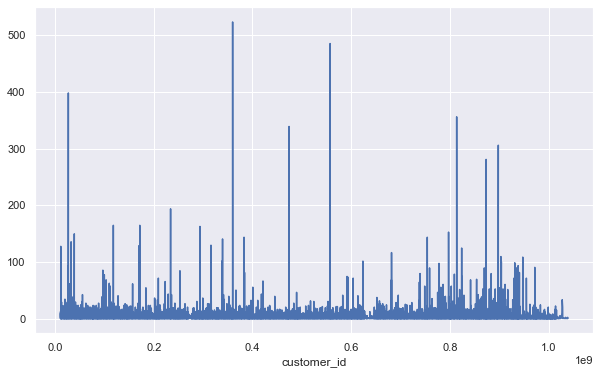

In [39]:
# опять сравнительно небольшое количество покупателей, у которых очень большое КОЛИЧЕСТВО ЗАКАЗОВ

plt.figure(figsize=(10,6))
df_delivered_freq.plot()

Настолько высокочастотные покупатели это подозрительно. Возможно, это корпоративные аккаунты или вроде того. Если так, то скорее всего в их составе разные категории и/или большое количество позиций. Проверим 20 самых высокочастотных покупателей - действительно разнообразие категорий в среднем высоко (столбец category_id - nunique) из максимальных 16, так же и объем совокупных закупок в единицах высок (столбец items_qty - sum):

In [40]:
df_hiqh_freq = df_delivered_freq.sort_values()[-20:]
df[df['customer_id'].isin(df_hiqh_freq.index)].groupby(['customer_id'])[['category_id', 'items_qty']].agg(['sum', 'nunique'])

category_id         items_qty        
                    sum nunique       sum nunique
customer_id                                      
11835650           1189      11       301      10
27118041           4806       3       591      10
32715298           1619      10       233       7
39178271           1842       7       278       9
118248692          2118       9       581      11
169969043          1545       3       268       6
171849217          2228       9       300       4
234194439          1929       8       511       8
293717885           805       9      1568      28
316013915           798       6      1174      26
339445972           652       5      1347      32
359859048          2195       7      4612      38
382993141          1966      10       312       6
474193719          1464       8      3708      40
557309662          5816      11      1589      21
754115812          1623       4       245       8
797239655           671       3      1178      20
813646679          1449       4      4053      32
873330132          3210       7       515      10
897973115          1229       2      4037      30

In [41]:
# прикинем разумные границы по КОЛИЧЕСТВУ ЗАКАЗОВ на покупателей. Допустим выброс это частота 26 и более заказов за год

print('Всего покупателей:', df_delivered_freq.count())
print('Покупатели у которых от 26 заказов за год:',(df_delivered_freq > 25).sum())
print('То есть покупателей-выбросов от всех покупателей % равный:', (df_delivered_freq > 25).sum() / df_delivered_freq.sum() * 100)
print('Всего покупателей без выбросов:', df_delivered_freq[df_delivered_freq <= 25].count())
print('Средняя частота за год на одного покупателя без учета выбросов:', df_delivered_freq[df_delivered_freq <= 25].mean())

Всего покупателей: 195485
Покупатели у которых от 26 заказов за год: 199
То есть покупателей-выбросов от всех покупателей % равный: 0.056429567959348025
Всего покупателей без выбросов: 195286
Средняя частота за год на одного покупателя без учета выбросов: 1.7391722908964289


In [42]:
# выделим покупателей с нормальным КОЛИЧЕСТВОМ ЗАКАЗОВ, до 25 включительно

df_delivered_25orders = df[df['customer_id'].isin((df_delivered_freq[df_delivered_freq <= 25]).index)]
df_delivered_25orders

,creation_date,Year,Month,region_id,customer_id,order_id,order_status,category_id,order_sum,items_qty
529604,2019-01-01,2019,1,1175,759894626,9264274,DELIVERED,16,8021,1
304498,2019-01-01,2019,1,1125,773011457,9265582,DELIVERED,16,8191,1
250381,2019-01-01,2019,1,1125,774046027,9266234,DELIVERED,16,8191,1
528016,2019-01-01,2019,1,1225,686211918,9271396,DELIVERED,12,8434,1
126796,2019-01-01,2019,1,1625,796520652,9266324,DELIVERED,2,2554,3
...,...,...,...,...,...,...,...,...,...,...
111852,2019-12-31,2019,12,975,25933585,25218210,DELIVERED,2,9901,1
338718,2019-12-31,2019,12,150,263019119,25205856,DELIVERED,2,1450,1
264522,2019-12-31,2019,12,1175,462447886,25209092,DELIVERED,16,27286,1
409150,2019-12-31,2019,12,24175,1010429215,25204122,DELIVERED,12,4981,1


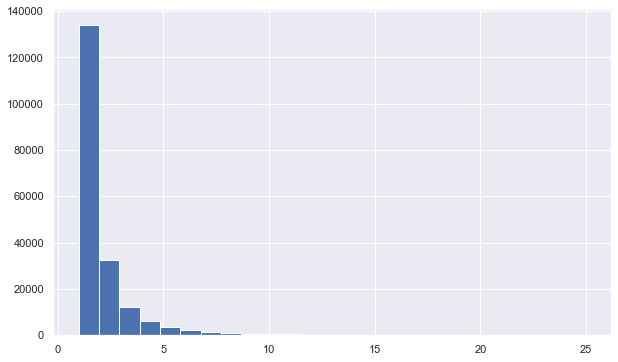

In [43]:
# вид по КОЛИЧЕСТВУ ЗАКАЗОВ ожидаемый - логнормальное распределение

plt.figure(figsize=(10,6))
df_delivered_25orders.groupby(['customer_id'])['order_id'].nunique().hist(bins = 25)

**1.4г. Разнообразие товарных категорий на покупателя**

In [44]:
# посмотрим подробнее по ШИРОТЕ АССОРТИМЕНТА, который покупают (среднее количество категорий в заказе)

df_assortment = df.groupby(['customer_id', 'order_id'])['category_id'].size().to_frame().groupby(['customer_id'])['category_id'].mean()
df_assortment = df_assortment.rename('assortment', inplace=True).sort_values().to_frame().reset_index().groupby(['assortment'])['customer_id'].count().sort_values()
df_assortment.to_frame()

,customer_id
assortment,
1.681818,1
1.652174,1
1.687500,1
1.708333,1
1.736842,1
...,...
1.333333,2873
3.000000,4692
1.500000,6596


150978 покупателей покупали не более 1 категории в каждом заказе. Глубина ассортимента очевидно потребуется учесть при выделении лояльных.

#### 1.4д. Пересечение выбросов по общей сумме, среднему чеку и частоте заказов:

In [45]:
# проверим, как пересекаются выбросы и получим список покупателей, которые являются выбросами хотя бы по одному из этих критериев

df_order_sum_index = df_order_sum[df_order_sum > 60000].index # customers_id выбросов по ОБЩЕЙ СУММЕ
df_order_mean_index = df_order_mean[df_order_mean > 30000].index # customers_id выбросов по СРЕДНЕМУ ЧЕКУ
df_delivered_freq_index = df_delivered_freq[df_delivered_freq > 25].index # customers_id выбросов по КОЛИЧЕСТВУ ПОКУПОК

outlier_id = list(set(df_order_sum_index.append(df_order_mean_index).append(df_delivered_freq_index)))

print('Всего аномальных покупателей хотя бы по одному параметру:', len(outlier_id))
print('Что составляет % от всех покупателей равный:', len(outlier_id) / df['customer_id'].nunique() * 100)

Всего аномальных покупателей хотя бы по одному параметру: 2564
Что составляет % от всех покупателей равный: 1.3116095864132797


**1.5 Выводы по разведочному анализу:**

**1)** **Главное: в целом данные по общей сумме на покупателя, по среднему чеку на покупателя, по количеству/частоте заказов подчиняются нормальному распределению.**  
**2)** Есть явные выбросы по общей сумме (**0.8%** от всех), по среднему чеку (**0.6%** от всех), по количеству/частоте заказов (**0.06%** от всех) - всего с учетом пересечения это **1.3%** от всех покупателей. Вполне вероятно, это корпоративные аккаунты или иные обособленные сущности.  
**3)** Очевиден сильный рост от низкой базы (нулевой - открытие в ноябре 2018), что осложняет выведение сезонности.  
**4)** Наблюдается значительный рост отмен заказов как в количественном, так и в денежном выражении со второй половины 2019 года. Возможно, это вызвано повышением минимальной стоимости заказа для использования купона (попытка "добрать" и затем раскаяние).  
**5)** **16я** и **7я** категории дорогие и относительно частопокупаемые. При это по ним очень высок уровень отказов как по количеству, так и в денежном выражении. Возможно, это бытовая техника, гаджеты или другая дорогая техника, покупку которой обдумывают серьезно, потому высокий процент отказов. Вероятно делают заказ, а потом находят другой магазин с лучшими условиями по цене/доставке и т.д.  
**6)**  Важнейшие регионы: **875, 975, 1175, 1075, 1625, 950**.
875 (очень большой дохода, но ещё больше потерянных на отказах денег), 975 и 1175 (очень большой объем потерь в деньгах), 1075, 1625 и 950 - очевидно в этих 3 регионах деньги и готовность покупать есть, но что-то ведет к большой сумме потерь в деньгах и количеству отмененных заказов. Вероятно, всё это это крупные города (может быть некоторые даже субрегионы). На эти 6 регионов приходится **45%** доходов.

# 2. Бизнес-метрики

Метрики:
1. ***Customer Retention Rate (CRR)*** = (total clients on end period - total new clients for period) / total clients on first period 
2. ***Churn Rate (CR)*** = total clients lost / total clients on first period 
3. ***Average Customer Lifetime (ACL)*** = 1 / churn rate
4. ***Customer Value (CV)*** 

Average Order Value (AOV) = total revenue / number of orders   
Purchase Frequency (PF) = total orders / unique customers  
Customer Value (CV) = AOV * PF
5. ***Repeat Purchase Rate (RPR)***

Repeat Purchase Rate (RPR) = number of customers who bought more than once for period / total number of customers for period
6. Так же, для информативности, выведем в реальном выражении значения количества покупателей:  
**'Количество клиентов на начало периода' (clients_period_start)**,  
**'Количество клиентов на конец периода' (clients_period_end)**,  
**'Количество новых клиентов' (clients_new)**,  
**'Пересечение клиентов в конце и начале периода' (clients_intersect)**,  
**'Количество ушедших клиентов' (clients_lost)**.  

Сделаем расчеты бизнес-метрик:

In [46]:
# т.к. аномальных надо изучить отдельно, разделим нормальных и аномальных
# нормальные - СРЕДНИЙ ЧЕК менее 30 тыс руб, ОБЩАЯ СУММА ПОКУПОК менее 60 тыс, ЧАСТОТА до 25 (включительно) заказов в год 

normal_customer_id = df[~df['customer_id'].isin(outlier_id)]['customer_id'].unique()
anomal_customer_id_save = df[df['customer_id'].isin(outlier_id)]['customer_id'].unique()
anomal_customer_id = outlier_id

print('Количество нормальных покупателей:', len(normal_customer_id))
print('Количество аномальных покупателей:', len(anomal_customer_id))
print('Аномальные составляют, в % от всех:', len(anomal_customer_id) / (len(anomal_customer_id) + len(normal_customer_id)) * 100)

Количество нормальных покупателей: 192921
Количество аномальных покупателей: 2564
Аномальные составляют, в % от всех: 1.3116095864132797


In [47]:
# сконцентрируемся на нормальных, без выбросов, но отложим в сторону полный набор (df_save)

df_save = df
df = df[df['customer_id'].isin(normal_customer_id)]

#### 2.1. Расчет CRR, CR, ACL + изменение количества покупателей:

In [48]:
# CRR, CR, ACL + изменение количества покупателей - метрики, которые будут МЕСЯЦ К МЕСЯЦУ: 

# для удобства создадим функцию, которая всё посчитает и запишет в словарь

# сustomer retention rate (CRR) = (total clients on end period - total new clients for period) / total clients on first period
# churn rate (CR) = total clients lost / total clients on first period
# average customer lifetime (ACL) = 1 / churn rate 

mertics_dict = {}

def crr_cr_acl(df):

    for i in range(1, len(df['Month'].unique())):
        total_clients_on_first = df[df['Month'] == i]['customer_id'].unique()
        total_clients_on_end = df[df['Month'] == i+1]['customer_id'].unique()
        total_clients_on_first_count = df[df['Month'] == i]['customer_id'].nunique()
        total_clients_on_end_count = df[df['Month'] == i+1]['customer_id'].nunique()
        intersection = len(set(total_clients_on_end).intersection(total_clients_on_first))
        count_new_clients = total_clients_on_end_count - intersection
        total_clients_lost = total_clients_on_first_count - intersection
    
        crr = round(((total_clients_on_end_count - count_new_clients) / total_clients_on_first_count) * 100, 2)
        cr = round(total_clients_lost / total_clients_on_first_count * 100, 2)
        acl = round(1 / cr * 100, 2)
        
        mertics_dict[i+1] = [total_clients_on_first_count, total_clients_on_end_count, count_new_clients, intersection, total_clients_lost, crr, cr, acl]

crr_cr_acl(df)

In [49]:
# для полноты оценки динамики добавим для CRR, CR, ACL данные за январь 2019 (к декабрю 2018, т.к. 2018 у нас в отдельно)

total_clients_on_first = df2018[(df2018['Month'] == 12) & (df2018['order_status'] == 'DELIVERED')]['customer_id'].unique()
total_clients_on_end = df[df['Month'] == 1]['customer_id'].unique()
total_clients_on_first_count = df2018[(df2018['Month'] == 12) & (df2018['order_status'] == 'DELIVERED')]['customer_id'].nunique()
total_clients_on_end_count = df[df['Month'] == 1]['customer_id'].nunique()
intersection = len(set(total_clients_on_end).intersection(total_clients_on_first))
count_new_clients = total_clients_on_end_count - intersection
total_clients_lost = total_clients_on_first_count - intersection
    
crr2019 = round(((total_clients_on_end_count - count_new_clients) / total_clients_on_first_count) * 100, 2)
cr2019 = round(total_clients_lost / total_clients_on_first_count * 100, 2)
acl2019 = round(1 / cr2019 * 100, 2)

mertics_dict[1] = [total_clients_on_first_count, total_clients_on_end_count, total_clients_lost, intersection, total_clients_lost, crr2019, cr2019, acl2019]

In [50]:
# и отдельно посчитаем CRR, CR, ACL начало к концу года (декабрь 2019 к январю 2019)

total_clients_on_first = df[df['Month'] == 1]['customer_id'].unique()
total_clients_on_end = df[df['Month'] == 12]['customer_id'].unique()
total_clients_on_first_count = df[df['Month'] == 1]['customer_id'].nunique()
total_clients_on_end_count = df[df['Month'] == 12]['customer_id'].nunique()
intersection = len(set(total_clients_on_end).intersection(total_clients_on_first))
count_new_clients = total_clients_on_end_count - intersection
total_clients_lost = total_clients_on_first_count - intersection
    
crr2019 = round(((total_clients_on_end_count - count_new_clients) / total_clients_on_first_count) * 100, 2)
cr2019 = round(total_clients_lost / total_clients_on_first_count * 100, 2)
acl2019 = round(1 / cr2019 * 100, 2)
    
mertics_dict[13] = [total_clients_on_first_count, total_clients_on_end_count, total_clients_lost, intersection, total_clients_lost, crr2019, cr2019, acl2019]

#### 2.2.  Расчет RPR, AOV, PF, CV:

In [51]:
# RPR, AOV, PF, CV - метрики, что будут ЗА МЕСЯЦ: 

# для удобства создадим функцию, которая всё посчитает и добавит в словарь, где уже есть CRR, CR, ACL

# repeat purchase rate (RPR) = number of customers who bought more than once for period / total number of customers for period
# average order value (AOV) = total revenue / number of orders
# purchase frequency (PF) = total orders / unique customers
# customer value (CV) = aov * pf

def delivery_count_calc(df):
                
    df['order_deliv_count'] = 0
    delivered_count = df.groupby(['customer_id'])['order_id'].nunique()
    for i in delivered_count.unique():
        index = delivered_count[delivered_count == i].index
        df['order_deliv_count'].at[df['customer_id'].isin(index)] = i

def rpr_aov_pf_cv(df):
    for i in df['Month'].unique():
        rpr = round((df[(df['order_deliv_count'] >= 2) & (df['Month'] == i)]['order_id'].nunique() / 
                df[(df['order_deliv_count'] >= 1) & (df['Month'] == i)]['order_id'].nunique()) * 100, 2)
        mertics_dict[i].append(rpr)
        aov = round(df[df['Month'] == i].groupby(['customer_id'])['order_sum'].sum() / 
                    df[df['Month'] == i].groupby(['customer_id'])['order_id'].nunique(), 2)
        mertics_dict[i].append(round(aov.mean(), 2))
        pf = round(df[df['Month'] == i]['order_id'].nunique() / 
                   df[df['Month'] == i]['customer_id'].drop_duplicates().nunique(), 2)
        mertics_dict[i].append(pf)
        cv = round(aov.mean() * pf, 2)
        mertics_dict[i].append(cv)
         
delivery_count_calc(df)
rpr_aov_pf_cv(df)

<ipython-input-51-f07808e89e77>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_deliv_count'] = 0
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:1142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [52]:
# и отдельно посчитаем RPR, AOV, PF, CV за 2019 год

rpr = round(df[df['order_deliv_count'] >= 2]['order_id'].nunique() / df[df['order_deliv_count'] >= 1]['order_id'].nunique() * 100, 2)
mertics_dict[13].append(rpr)

aov = round(df.groupby(['customer_id'])['order_sum'].sum() / df.groupby(['customer_id'])['order_id'].nunique(), 2)
mertics_dict[13].append(aov.mean())

pf = round(df['order_id'].nunique() / df['customer_id'].drop_duplicates().count(), 2)
mertics_dict[13].append(pf)

cv = round(aov.mean() * pf, 2)
mertics_dict[13].append(cv)

del df['order_deliv_count']

#### 2.3 Единая таблица и анализ метрик:

In [53]:
# сделаем из словаря, куда всё собрали, таблицу со всеми метриками
# 13 строка - за год в целом. такие показатели как clients_period_start, clients_period_end, clients_new, 
# clients_intersect, clients_lost для неё не очень информативны т.к. отражают период декабрь 2019 к январю 2019

metrix = pd.DataFrame.from_dict(mertics_dict, orient='index', columns=['clients_period_start', 'clients_period_end', 'clients_new', 'clients_intersect', 'clients_lost', 'CRR', 'CR', 'ACL', 'RPR', 'AOV', 'PF', 'CV'])
metrix.sort_index(inplace=True)
metrix

,clients_period_start,clients_period_end,clients_new,clients_intersect,clients_lost,CRR,CR,ACL,RPR,AOV,PF,CV
1,10098,15033,8965,1133,8965,11.22,88.78,1.13,58.29,4412.080000,1.11,4897.41
2,15033,16102,14293,1809,13224,12.03,87.97,1.14,60.18,4161.830000,1.12,4661.25
3,16102,17905,15688,2217,13885,13.77,86.23,1.16,62.91,4229.660000,1.17,4948.71
4,17905,18521,16190,2331,15574,13.02,86.98,1.15,61.86,4017.890000,1.15,4620.57
5,18521,20178,17423,2755,15766,14.88,85.12,1.17,64.76,3811.290000,1.17,4459.21
6,20178,22472,19390,3082,17096,15.27,84.73,1.18,58.82,3998.770000,1.12,4478.62
7,22472,22775,19824,2951,19521,13.13,86.87,1.15,59.47,3880.860000,1.13,4385.37
8,22775,25120,21742,3378,19397,14.83,85.17,1.17,59.97,4010.290000,1.13,4531.63
9,25120,24884,21139,3745,21375,14.91,85.09,1.18,59.74,3982.560000,1.12,4460.46
10,24884,30313,26157,4156,20728,16.70,83.30,1.20,60.10,3900.430000,1.16,4524.50


In [54]:
# заодно выведем среднемесячные показатели за год:

metrix.iloc[:12, 5:].mean().to_frame().T

,CRR,CR,ACL,RPR,AOV,PF,CV
0,14.474167,85.525833,1.17,59.644167,4047.551667,1.138333,4606.315


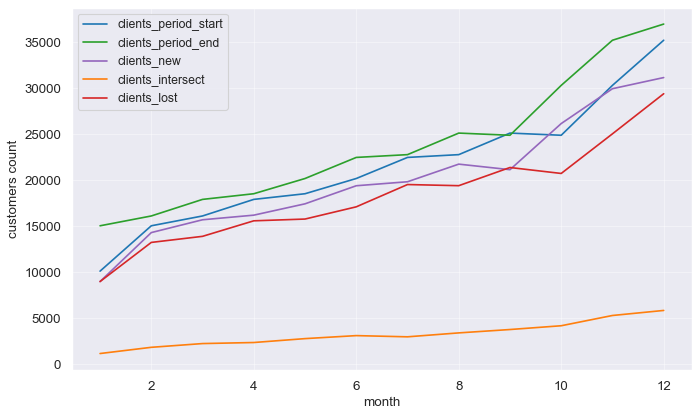

In [55]:
# нарисуем график, куда выведем изменение количества покупателей, по месяцам

x = metrix.index[:12]
y1 = metrix['clients_period_start'][:12]
y2 = metrix['clients_period_end'][:12]
y3 = metrix['clients_new'][:12]
y4 = metrix['clients_intersect'][:12]
y5 = metrix['clients_lost'][:12]

fig, ax1 = plt.subplots(1, 1, figsize = (10, 6), dpi = 80)
ax1.plot(x, y1, color='tab:blue', label='clients_period_start')
ax1.plot(x, y2, color='tab:green', label='clients_period_end')
ax1.plot(x, y3, color='tab:purple', label='clients_new')
ax1.plot(x, y4, color='tab:orange', label='clients_intersect')
ax1.plot(x, y5, color='tab:red', label='clients_lost')
ax1.legend(loc='upper left')

ax1.set_xlabel('month', fontsize=12)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('customers count', fontsize=12)
ax1.tick_params(axis='y', rotation=0, labelsize=12)
ax1.grid(alpha=.4)

Очевидно растет всё, что характерно для успешного бизнеса в стадии роста.   
При этом каждый месяц количество клиентов больше, чем в предыдущем. Только сентябрь по отношению к августу оказался не очень: и спад в темпе прироста новых покупателей, и всего количество покупателей оказалось чуть меньше.  
Важно отметить, что и пересечение плавно подрастает - важный источник лояльности. 

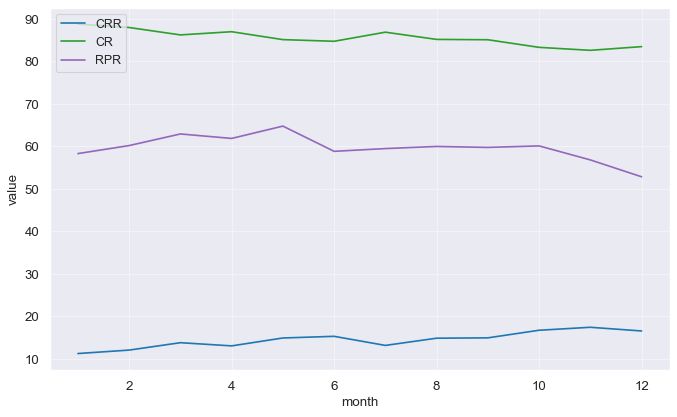

In [56]:
# теперь посмотрим на CRR, CR и RPR, по месяцам 

x = metrix.index[:12]
y1 = metrix['CRR'][:12]
y2 = metrix['CR'][:12]
y3 = metrix['RPR'][:12]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6), dpi= 80)
ax1.plot(x, y1, color='tab:blue', label='CRR')
ax1.plot(x, y2, color='tab:green', label='CR')
ax1.plot(x, y3, color='tab:purple', label='RPR')

ax1.legend(loc='upper left')

ax1.set_xlabel('month', fontsize=12)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('value', fontsize=12)
ax1.tick_params(axis='y', rotation=0, labelsize=12)
ax1.grid(alpha=.4)

В целом от месяца к месяцу значения метрик удержание клиентов, отток и процент повторных покупок стабильны.

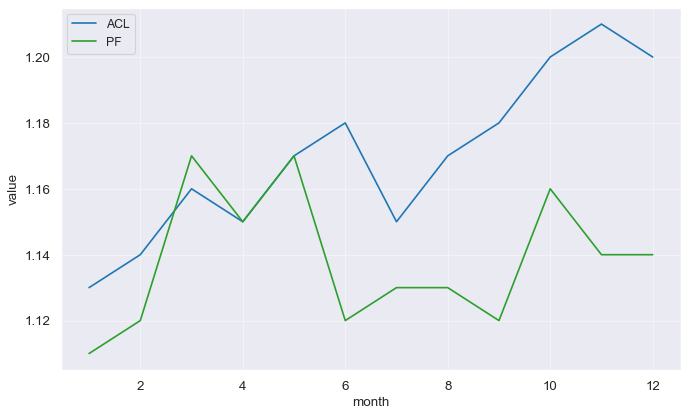

In [57]:
# теперь посмотрим на ACL и PF, по месяцам

x = metrix.index[:12]
y1 = metrix['ACL'][:12]
y2 = metrix['PF'][:12]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6), dpi= 80)
ax1.plot(x, y1, color='tab:blue', label='ACL')
ax1.plot(x, y2, color='tab:green', label='PF')

ax1.legend(loc='upper left')

ax1.set_xlabel('month', fontsize=12)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('value', fontsize=12)
ax1.tick_params(axis='y', rotation=0, labelsize=12)
ax1.grid(alpha=.4)

Среднее время жизни клиента всегда больше месяца, частота покупки на покупателя так же всегда больше 1. 

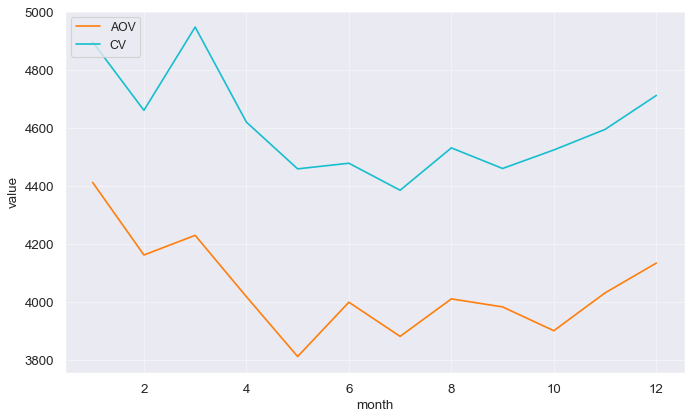

In [58]:
# теперь посмотрим на AOV и CV, по месяцам

x = metrix.index[:12]
y1 = metrix['AOV'][:12]
y2 = metrix['CV'][:12]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6), dpi= 80)
ax1.plot(x, y1, color='tab:orange', label='AOV')
ax1.plot(x, y2, color='tab:cyan', label='CV')
ax1.legend(loc='upper left')

ax1.set_xlabel('month', fontsize=12)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('value', fontsize=12)
ax1.tick_params(axis='y', rotation=0, labelsize=12)
ax1.grid(alpha=.4)

Средняя стоимость заказа просела в середине года, следовательно и средний доход от покупателя тогда же снизился. В последнем квартале 2019 года оба показателя выросли.

#### 2.4. Выводы по бизнес-метрикам:  

**1)** Очевидно растет всё, что характерно для успешного бизнеса в стадии роста.
При этом каждый месяц количество клиентов больше, чем в предыдущем. Только сентябрь по отношению к августу оказался не очень: и спад в темпе прироста новых покупателей, и всего количество покупателей оказалось чуть меньше.
Важно отметить, что и пересечение (**clients_intersect**) плавно подрастает - важный источник лояльности.  
**2)** В целом от месяца к месяцу значения метрик удержание клиентов (**CRR**), отток (**CR**) и процент повторных покупок (**RPR**) стабильны.   
**3)** Среднее время жизни клиента (**ACL**) всегда больше месяца, средняя частота покупки на покупателя (**PF**) так же всегда больше 1.  
**4)** Средняя стоимость заказа (**AOV**) просела в середине года, следовательно и средний доход от покупателя (**CV**) тогда же снизился. В последнем квартале 2019 года оба показателя выросли.  
Среднемесячные значения бизнес-метрик за 2019 год:  
**- CRR** - **14.47%**  
**- CR** - **85.52%**  
**- ACL** - **1.17%**  
**- PF** - **1.14%**  
**- RPR** - **59.64%**   
**- AOV** - **4047.55 рублей**  
**- CV** - **4606.32 рублей**  

# 3. Выделение лояльных покупателей, критерии и оценка

Для выделения лояльных покупателей потребуются показатели по разным основаниям - деньги, частота, разнообразие покупок (категории в корзине). Мы уже анализировали их (и связанные с ними) при разведочном анализе и оценке бизнес-метрик, поэтому считаем что они в качестве критериев хорошо описывают кластеры (лояльных и нет).

Посчитаем для каждого покупателя:  

**Деньги:**  
**1)** общая сумма покупок покупателя за год (***sum_bill_year***),  
**2)** средний чек покупателя за год (***av_bill_year***),   
  
**Частота:**  
**3)** общее количество заказов за год (***order_count_year***),   
**4)** среднее количество заказов в месяц (***av_order_per_month***),    
  
**Категории:**   
**5)** общее количество уникальных категорий за год (***uniq_cat_per_year***),  
**6)** среднее количество уникальных категорий в месяц (***av_cat_count_month***),  
**7)** среднее количество уникальных категорий в год (***av_cat_per_pur_year***).

#### 3.1. Расчет кластеризующих показателей:

In [59]:
# общая сумма покупок покупателя за год (sum_bill_year)

sum_bill_year = df.groupby(['customer_id'])['order_sum'].sum()  
sum_bill_year.rename('sum_bill_year', inplace=True).sort_values()

customer_id
983399189      501
363589055      501
861165231      501
166450395      501
778520460      501
             ...  
134299169    59896
160343299    59909
862220363    59916
607223536    59916
529616975    59964
Name: sum_bill_year, Length: 192921, dtype: int64

In [60]:
# средний чек покупателя за год (av_bill_year)

av_bill_year = df.groupby(['customer_id'])['order_sum'].sum() / df.groupby(['customer_id'])['order_id'].nunique()
av_bill_year.rename('av_bill_year', inplace=True).sort_values()

customer_id
166450395       501.0
213451102       501.0
980096204       501.0
491672528       501.0
673603387       501.0
               ...   
299574916     53212.0
799968498     53370.0
1010341951    54833.0
105776270     58227.0
607223536     59916.0
Name: av_bill_year, Length: 192921, dtype: float64

In [61]:
# общее количество заказов за год (order_count_year)

order_count_year = df.groupby(['customer_id'])['order_id'].nunique()
order_count_year.rename('order_count_year', inplace=True).sort_values()

customer_id
11113014      1
699865694     1
699873330     1
699880752     1
699881812     1
             ..
719211853    24
235019645    24
127321554    25
864114545    25
671474867    25
Name: order_count_year, Length: 192921, dtype: int64

In [62]:
# среднее количество заказов в месяц (av_order_per_month)

av_order_per_month = df.groupby(['customer_id'])['order_id'].nunique() / 12
av_order_per_month.rename('av_order_per_month', inplace=True).sort_values()

customer_id
11113014     0.083333
699865694    0.083333
699873330    0.083333
699880752    0.083333
699881812    0.083333
               ...   
719211853    2.000000
235019645    2.000000
127321554    2.083333
864114545    2.083333
671474867    2.083333
Name: av_order_per_month, Length: 192921, dtype: float64

In [63]:
# общее количество уникальных категорий за год (uniq_cat_per_year)

uniq_cat_per_year = df.groupby(['customer_id'])['category_id'].nunique()
uniq_cat_per_year.rename('uniq_cat_per_year', inplace=True).sort_values()

customer_id
11113014      1
681408956     1
681409042     1
681411883     1
681419671     1
             ..
347168318    12
62432939     12
613794393    12
371992887    12
663620196    12
Name: uniq_cat_per_year, Length: 192921, dtype: int64

In [64]:
# среднее количество уникальных категорий в месяц (av_cat_count_month)

av_cat_count_month = df.groupby(['customer_id'])['category_id'].nunique() / 12
av_cat_count_month.rename('av_cat_count_month', inplace=True).sort_values()

customer_id
11113014     0.083333
681408956    0.083333
681409042    0.083333
681411883    0.083333
681419671    0.083333
               ...   
347168318    1.000000
62432939     1.000000
613794393    1.000000
371992887    1.000000
663620196    1.000000
Name: av_cat_count_month, Length: 192921, dtype: float64

In [65]:
# среднее количество уникальных категорий в год (av_cat_per_pur_year)

av_cat_per_pur_year = df.groupby(['customer_id', 'order_id'])['category_id'].size().to_frame().groupby(['customer_id'])['category_id'].mean()
av_cat_per_pur_year.rename('av_cat_per_pur_year', inplace=True).sort_values()

customer_id
11113014      1.0
722619041     1.0
722697123     1.0
722896142     1.0
722926100     1.0
             ... 
453851635     7.0
682146312     7.0
552594674     8.0
881742512     8.0
267014576    10.0
Name: av_cat_per_pur_year, Length: 192921, dtype: float64

In [66]:
# объединим все показатели в единую таблицу

logic_stat = [sum_bill_year, av_bill_year, order_count_year, av_order_per_month, uniq_cat_per_year, av_cat_count_month, av_cat_per_pur_year]
logic_metrix = pd.DataFrame()

for i in logic_stat:
    logic_metrix.insert(0, i.name, i, True)
    
logic_metrix

,av_cat_per_pur_year,av_cat_count_month,uniq_cat_per_year,av_order_per_month,order_count_year,av_bill_year,sum_bill_year
customer_id,,,,,,,
11113014,1.0,0.083333,1,0.083333,1,9893.0,9893
11121128,2.0,0.166667,2,0.083333,1,11410.0,11410
11121350,1.0,0.083333,1,0.083333,1,805.0,805
11121469,1.0,0.166667,2,0.166667,2,2549.5,5099
11121729,1.0,0.166667,2,0.166667,2,3282.5,6565
...,...,...,...,...,...,...,...
1036819888,1.0,0.083333,1,0.083333,1,756.0,756
1038172005,1.0,0.083333,1,0.083333,1,3483.0,3483
1038338782,1.0,0.083333,1,0.083333,1,3714.0,3714


#### 3.2. Алгоритм kmeans для выделения лояльных:

Оценим количество кластеров по однородности данных (метод локтя):

In [67]:
# посмотрим, сколько вообще здесь может быть кластеров, по однородности

logic_metrix_scaling = np.nan_to_num(logic_metrix) 
logic_metrix_scaling = StandardScaler().fit_transform(logic_metrix_scaling) # стандартизируем переменные (для работы kmeans)

1 : 2.037595423006016
2 : 1.5653668719580276
3 : 1.405800530371479
4 : 1.2040135198148014
5 : 1.062248882967472
6 : 1.0206134393383477
7 : 0.9424981233554651
8 : 0.8410158426190681
9 : 0.8144830040621056


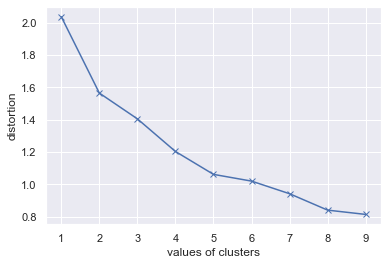

In [68]:
# посчитаем по методу локтя (где сильный излом)

distortions = []
mapping = {}
K = range(1,10) # вариация в 10 кластеров

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(logic_metrix_scaling)
    kmeanModel.fit(logic_metrix_scaling)    
    distortions.append(sum(np.min(cdist(logic_metrix_scaling, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / logic_metrix_scaling.shape[0])
   
    mapping[k] = sum(np.min(cdist(logic_metrix_scaling, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / logic_metrix_scaling.shape[0]
    
for key,val in mapping.items():
    print(str(key)+' : '+str(val))
        

plt.plot(K, distortions, 'bx-')
plt.xlabel('values of clusters')
plt.ylabel('distortion')
plt.show()

 Похоже действительно 2 кластера определяются, заметный излом после 2го. 

Применим **kmeans** (k = 2):

In [69]:
# разделим данные на 2 кластера

cluster_num = 2
k_means = KMeans(init = 'k-means++', n_clusters = cluster_num, n_init = 20, random_state = 42)
k_means.fit(logic_metrix_scaling)
labels = k_means.labels_
logic_metrix['cluster'] = labels

In [70]:
# посмотрим соотношение по количеству

logic_metrix.groupby(['cluster'])['av_cat_per_pur_year'].count().to_frame().rename(columns={'av_cat_per_pur_year':'count'})

,count
cluster,
0,33622
1,159299


In [71]:
# посмотрим средние значения показателей внутри каждого кластера: 1 - обычные, 0 - лояльные

logic_metrix.groupby(['cluster']).mean()

,av_cat_per_pur_year,av_cat_count_month,uniq_cat_per_year,av_order_per_month,order_count_year,av_bill_year,sum_bill_year
cluster,,,,,,,
0,1.862769,0.303375,3.640503,0.31411,3.769318,4430.622825,14815.92722
1,1.097817,0.101021,1.212249,0.10402,1.248238,4061.032763,4939.97472


Получается, что по предложенной кластеризации для лояльных характерно (**всё усреднено по покупателям соответствующего класса**):  
**1)** Покупать за одну покупку **1.86** уникальных категорий за год против **1.09** у обычных,  
**2)** Покупать за одну покупку в среднем **0.30** уникальных категории в месяц против **0.10** у обычных,  
**3)** Покупать всего в год **3.64** уникальных категории товара против **1.21** у обычных,  
**4)** Делать **0.31** покупку в месяц против **0.10** у обычных,  
**5)** Делать за год **3.77** покупки против **1.24** у обычных,  
**6)** Средний чек **4430** рублей против **4061** рубля у обычных,  
**7)** Суммарный объем затрат от покупателя **14816** рублей против **4940** рублей у обычных.  

In [72]:
# посмотрим в реальном и процентном выражении, сколько получается лояльных (кластер 0) от всех (с учетом аномальных)

print('Всего покупателей за 2019 год:', df_save['customer_id'].nunique())
print('Лояльные клиенты составляют человек:', logic_metrix.groupby(['cluster'])['av_cat_per_pur_year'].count()[0])
print('Что в процентном отношении от всех', logic_metrix.groupby(['cluster'])['av_cat_per_pur_year'].count()[0] / df_save['customer_id'].nunique())

Всего покупателей за 2019 год: 195485
Лояльные клиенты составляют человек: 33622
Что в процентном отношении от всех 0.17199273601555107


Здравому смыслу и всему, что мы видели выше при разведочном анализе и по бизнес-метрикам, соответствует как процент от покупателей (**17.2%**), так и факт более высоких значений по совершенно всем показателям.

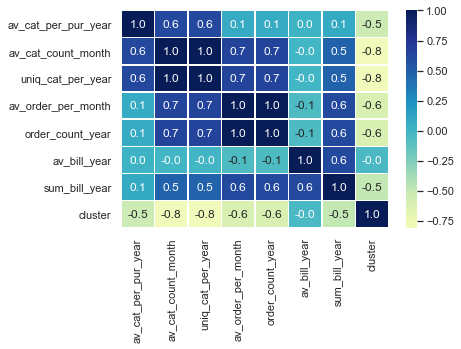

In [73]:
# посмотрим матрицу корелляций наших показателей

sns.heatmap(logic_metrix.corr(), center=0, annot=True, fmt='.1f', linewidths=.5, cmap="YlGnBu")

Можем сказать, что:  
**1)** усредненные и суммарные переменные кореллированы (ожидали этого),  
**2)** самые весомые для разделения на кластеры показатели это:   
- общее количество уникальных категорий за год (**uniq_cat_per_year**),   
- среднее количество уникальных категорий в месяц (**av_cat_count_month**).

Проверим полученную кластеризацию kmeans с помощью метрики **Silhouette**:  
Silhouette показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне от -1 до 1. Значения, близкие к 1 соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры.

In [74]:
silhouette_score(logic_metrix_scaling, labels, metric='euclidean')

0.5771112408640808

**Silhouette = 0.57**, результат достаточно хорош для бинарной кластеризации.

#### 3.3. Проверка кластеризации на бизнес-логику:

Проверим теперь в прикладном сысле, как обстоят дела с доходом, который приходится на лояльных от всех доходов. И заодно вспомним о тех, кого приняли за выбросы. 

In [75]:
# отберем список лояльных customer_id и отдельную таблицу только с ЛОЯЛЬНЫМИ

loyal_customers_index = logic_metrix[logic_metrix['cluster'] == 0]['cluster'].index
loyal_customers = df[df['customer_id'].isin(loyal_customers_index)]

print('Суммарный доход от ЛОЯЛЬНЫХ клиентов составляет:', loyal_customers.groupby(['customer_id'])['order_sum'].sum().sum())
print('Что в составляет от всех доходов, в %:', loyal_customers.groupby(['customer_id'])['order_sum'].sum().sum() / (df_save['order_sum'].sum()) * 100 )

Суммарный доход от ЛОЯЛЬНЫХ клиентов составляет: 498141105
Что в составляет от всех доходов, в %: 32.465242668316456


In [76]:
# а как дела у тех, кого признали АНОМАЛЬНЫМИ

print('Суммарный доход от АНОМАЛЬНЫХ клиентов составляет:', df_save[df_save['customer_id'].isin(anomal_customer_id)]['order_sum'].sum())
print('Что в составляет от всех доходов, в %:', df_save[df_save['customer_id'].isin(anomal_customer_id)]['order_sum'].sum() / (df_save['order_sum'].sum()) * 100 )

Суммарный доход от АНОМАЛЬНЫХ клиентов составляет: 249308679
Что в составляет от всех доходов, в %: 16.248140701122047


In [77]:
# то есть что получается совокупно для ЛОЯЛЬНЫЕ + АНОМАЛЬНЫЕ

print('Суммарный доход от ЛОЯЛЬНЫХ + АНОМАЛЬНЫХ клиентов составляет:', (df_save[df_save['customer_id'].isin(anomal_customer_id)]['order_sum'].sum()) + (loyal_customers.groupby(['customer_id'])['order_sum'].sum().sum()))
print('Что в составляет от всех доходов, в %:', ((df_save[df_save['customer_id'].isin(anomal_customer_id)]['order_sum'].sum()) + (loyal_customers.groupby(['customer_id'])['order_sum'].sum().sum())) / df_save['order_sum'].sum() * 100)

Суммарный доход от ЛОЯЛЬНЫХ + АНОМАЛЬНЫХ клиентов составляет: 747449784
Что в составляет от всех доходов, в %: 48.7133833694385


#### 3.4. Выводы по кластеризации:  

**1)** Количество лояльных клиентов было установлено с помощью алгоритма kmeans в размере 33550 человек, что составляет **17.2%** от всех покупателей. К обычным были отнесены, соответственно, 159371 человек (**81.5%**). Так же есть предварительно отобранные покупатели с "аномальным" поведением, 2564 человека (**1.3%**). Последние требуют совершенно обособленного подхода, т.к. часть информации о них и закономерностях их поведения могут быть за пределами доступной в представленных данных информации. Отметим дополнительно, что процент лояльных находится довольно близко к значению (и смыслу) бизнес-метрики **CRR**, что косвенно подтвержадет правильность оценки доли лояльных.   
**2)** Выбор прогнозирующих переменных был правильным, по основаниям: деньги (суммарные и в среднем, средний чек), частота (за год и в среднем), широта приобретаемого ассортимента, категорий (уникальные за месяц, за год, в одном заказе). Причем по важности для выделения лояльных касающиеся **широты ассортимента** оказались наиболее характеризующими, такие как:
- общее количество уникальных категорий за год (**uniq_cat_per_year**),  
- среднее количество уникальных категорий в месяц (**av_cat_count_month**).

**3)** В качестве метрики оценки качества кластеризации без учителя (без имеющихся тестовых данных с индикаторами отношения к классам) применена Silhouette. Значение **Silhouette = 0.57** (из доступного диапазона [-1; 1], где 1 лучший вариант), что можно признать достаточно хорошим результатом на имеющемся объеме данных.  
**4)** Установлено, что суммарный доход от лояльных покупателей составляет **32.4%** от всех за год. Это согласуется с логикой об ожидаемом непропорциональном вкладе лояльных.   
**5)** Все прогнозирующие переменные лояльных покупателей показали значительное превышение значений, чем у обычных покупателей. Средние значения переменных для лояльных покупателей:
- Покупать за одну покупку **1.86** уникальных категорий за год против **1.09** у обычных,  
- Покупать за одну покупку в среднем **0.30** уникальных категории в месяц против **0.10** у обычных,  
- Покупать всего в год **3.64** уникальных категории товара против **1.21** у обычных,  
- Делать **0.31** покупку в месяц против **0.10** у обычных,  
- Делать за год **3.77** покупки против **1.24** у обычных,  
- Средний чек **4430** рублей против **4061** рубля у обычных,  
- Суммарный объем затрат покупателя **14816** рублей против **4940** рублей у обычных.